In [2]:
%reset -f

In [3]:
import os
import numpy as np
from numpy import linalg as LA
import glob
import pandas as pd
import pyarrow.feather as feather
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
import math
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [4]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

# Remove the last folder from the current directory
parent_directory = os.path.dirname(current_directory)

# Get a list of all nc4 files in the directory
dataframe_files = glob.glob(os.path.join(current_directory, '*.feather'))

Current directory: d:\Experiments\Github_library\Python_Code


In [5]:
# Read the Feather file into a DataFrame
df = feather.read_feather(dataframe_files[0])
df.head()

,code,fraction,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,10.0,6.798829,0.007042,0.014132,0.020221,0.009273,0.000539,0.003194,0.014347,0.007172,...,0.005696,0.005484,0.004406,0.005140,0.006065,0.006807,0.011016,0.012942,0.013180,0.013624
1,10.0,6.171731,0.021585,0.014702,0.009741,0.013896,0.014213,0.009294,0.007103,0.006157,...,0.001482,0.002390,0.003200,0.003503,0.004160,0.001804,0.002697,0.005305,0.008501,0.009874
2,10.0,13.765575,0.009146,0.009724,0.021756,0.021899,0.013551,0.006502,0.011209,0.012004,...,0.018038,0.017510,0.019638,0.024364,0.023097,0.022890,0.023902,0.021637,0.024160,0.024723
3,10.0,13.786340,0.006213,0.014293,0.019478,0.027303,0.018228,0.003548,0.013680,0.012100,...,0.028519,0.028067,0.026137,0.025393,0.023391,0.022319,0.023621,0.023391,0.025350,0.026515
4,10.0,13.731441,0.014313,0.018730,0.012893,0.024081,0.020730,0.004751,0.003671,0.007563,...,0.027143,0.025403,0.025252,0.027084,0.028400,0.029292,0.030005,0.029653,0.028455,0.026979


In [6]:
df.describe()

,code,fraction,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,...,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,49.849374,24.815800,0.066155,0.063954,0.075084,0.069126,0.063363,0.063838,0.065216,0.062141,...,0.029264,0.029519,0.029716,0.029917,0.029996,0.030077,0.030230,0.030378,0.030513,0.030596
std,18.646341,13.979638,0.057066,0.057749,0.058159,0.058041,0.058242,0.058579,0.058401,0.058694,...,0.044323,0.044844,0.045258,0.045665,0.045937,0.046156,0.046318,0.046481,0.046654,0.046836
min,10.000000,0.497317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,13.901277,0.029796,0.027936,0.037930,0.032695,0.026870,0.027279,0.029228,0.026198,...,0.007716,0.007720,0.007825,0.007973,0.008003,0.007874,0.008251,0.008375,0.008559,0.008657
50%,60.000000,23.195217,0.050840,0.047529,0.059198,0.052036,0.045767,0.046205,0.046746,0.042892,...,0.015620,0.015837,0.016115,0.016352,0.015982,0.015873,0.016277,0.016571,0.016416,0.016439
75%,61.000000,34.073355,0.081182,0.078801,0.089728,0.084082,0.076736,0.077638,0.079312,0.075863,...,0.030139,0.030164,0.030272,0.030698,0.030911,0.031027,0.030393,0.030369,0.031149,0.030925
max,72.000000,81.651596,0.523905,0.514926,0.527593,0.540188,0.543387,0.541984,0.548595,0.551927,...,0.584288,0.592906,0.599787,0.606420,0.614522,0.620667,0.626338,0.631492,0.637253,0.641712


In [7]:
#The first column is categorical 
df['code']=df['code'].astype('category')

Material_names={1:'PET',2:'HDPE',3:'LDPE',4:'PP',5:'EPSF',6:'Mix',7:'Weathered'}
Background_names={0:'Clear',1:'Turbid',2:'Foamy'}
Material= [Material_names[x//10] for x in list(df['code'])]
Background= [Background_names[x%10] for x in list(df['code'])]
Settings=[Material_names[x//10]+'-'+Background_names[x%10] for x in list(df['code'])]
print(f"There are {len(set(Material))} and {len(set(Background))} uniue values in the material and background, respectivly.")
print(f"There are {len(set(Settings))} uniue values in the combined settings i.e. material & background.")

There are 7 and 3 uniue values in the material and background, respectivly.
There are 21 uniue values in the combined settings i.e. material & background.


In [8]:
#Adding new three columns in the dataframe representing Material, Background and combined settings 
df['Material']=Material
df['Background']=Background
df['Settings']=Settings
non_numeric_column=df.select_dtypes(exclude=['number']).columns.tolist()
print(f'There are {len(non_numeric_column)} columns with categorical values i.e. {non_numeric_column}')

There are 4 columns with categorical values i.e. ['code', 'Material', 'Background', 'Settings']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\olyae001\AppData\Local\Temp\ipykernel_3360\2789203500.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[j].set_yticklabels(y_lables,fontsize=25)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\olyae001\AppData\Local\Temp\ipykernel_3360\2789203500.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[j].set_yticklabels(y_lables,fontsize=25)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\olyae001\AppData\Local\Temp\ipykernel_3360\2789203500.py:20: UserWarning: FixedFormatter should only be used together with FixedLocato

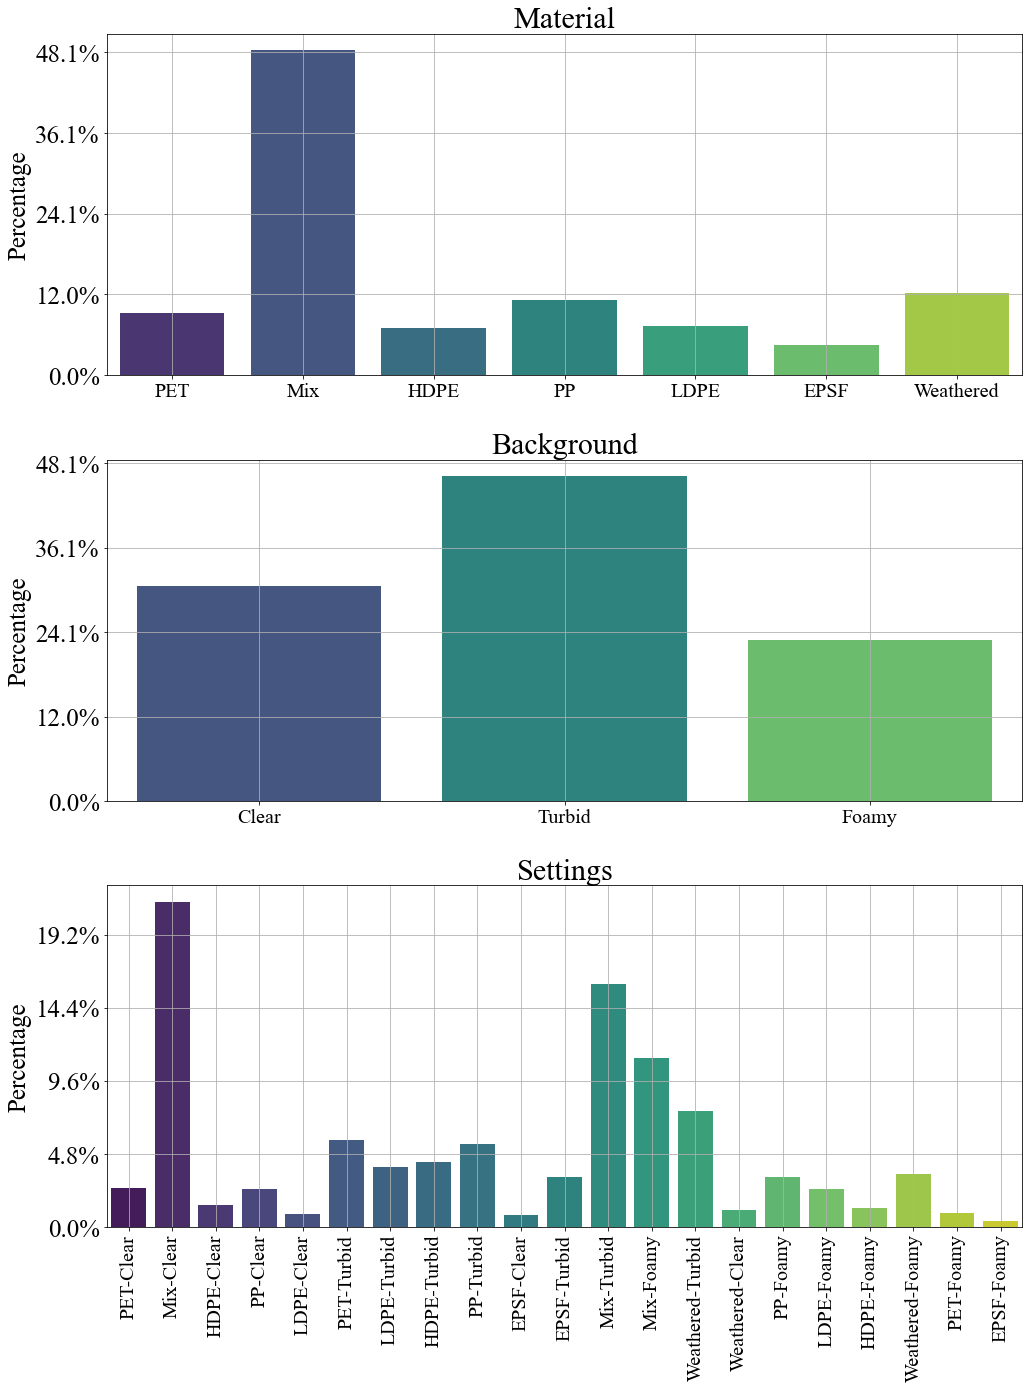

In [10]:
#Bar plot of number of measurements in terms of  Material, Background and combined settings 
figure, axes= plt.subplots(len(non_numeric_column)-1 ,1, figsize=(15,20))
axes=axes.flatten()
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=30
for i in range(1,len(non_numeric_column)):
    j=i-1
    total=len(df[non_numeric_column[i]])
    ax = sns.countplot(x=df[non_numeric_column[i]], hue=df[non_numeric_column[i]], ax=axes[j], palette=sns.color_palette("viridis", df[non_numeric_column[i]].nunique()))
    ax.legend().set_visible(False)
    xtick_labels = ax.get_xticklabels()
    axes[j].set_title(non_numeric_column[i],fontsize=30)
    axes[j].set_xlabel('')
    axes[j].set_ylabel('Percentage',fontsize=25)
    #for the combined settings we rotated the labels for a better display
    if i == len(non_numeric_column)-1:
        axes[j].tick_params(axis='x', rotation=90)
    #Convert y label into percentage
    y_lables=[f'{(val/total)*100:.1f}%' for val in ax.get_yticks()]
    axes[j].set_yticklabels(y_lables,fontsize=25)
    axes[j].grid(True) 
    axes[j].tick_params(axis='x', labelsize=20)
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=30
plt.tight_layout()
plt.show()    

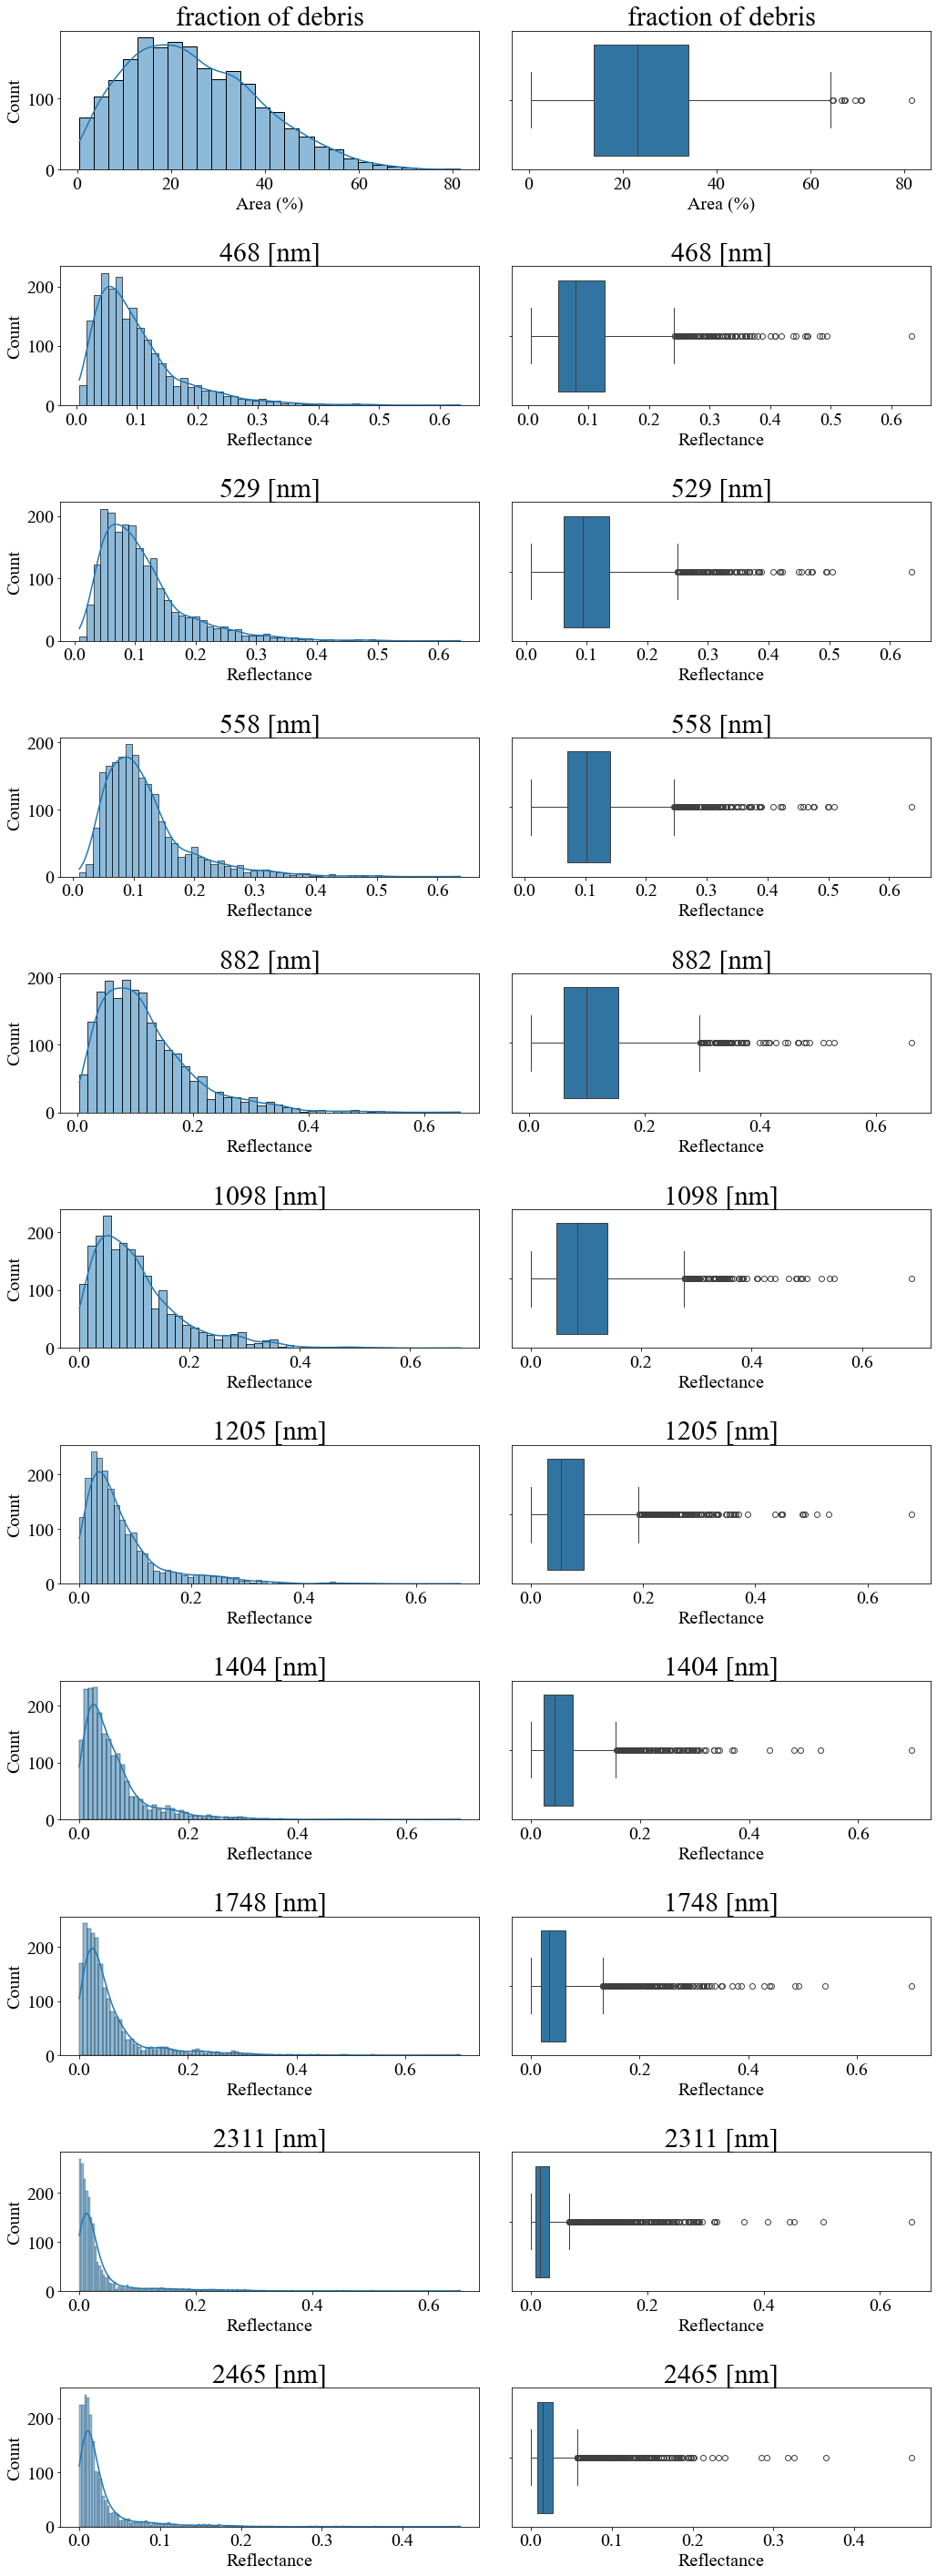

In [11]:
# K-S density distribution and box plot of plastic fraction and selected number of bands
numeric_column=df.select_dtypes(include=['number']).columns.tolist() #Becuase only numeric data involved in this part
k=10 #Number of bands to represent its distribution and box plot
selected_numeric=[numeric_column[0]]+[numeric_column[i] for i in sorted(np.random.randint(1,len(numeric_column),k))]

figure, axes=plt.subplots(k+1,2, figsize=(15,4*k))
axes=axes.flatten()
Label=['Area (%)','Reflectance']
Units=['of debris','[nm]'] #For displaying above the plots
for i in range(k+1):
    hist1=sns.histplot(x=df[selected_numeric[i]],kde=True,ax=axes[2*i])
    box1=sns.boxplot(x=df[selected_numeric[i]], ax=axes[2*i+1])
    axes[2*i].set_xlabel(Label[math.ceil(i/(i+1))],fontsize=20)
    axes[2*i].set_ylabel('Count',fontsize=20)
    axes[2*i+1].set_xlabel(Label[math.ceil(i/(i+1))],fontsize=20)
    axes[2*i].set_title(selected_numeric[i]+' '+ Units[math.ceil(i/(i+1))],fontsize=30)
    axes[2*i].tick_params(axis='both', labelsize=20)
    axes[2*i+1].tick_params(axis='both', labelsize=20)
    axes[2*i+1].set_title(selected_numeric[i]+' '+ Units[math.ceil(i/(i+1))],fontsize=30)
plt.tight_layout()
plt.show()    

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


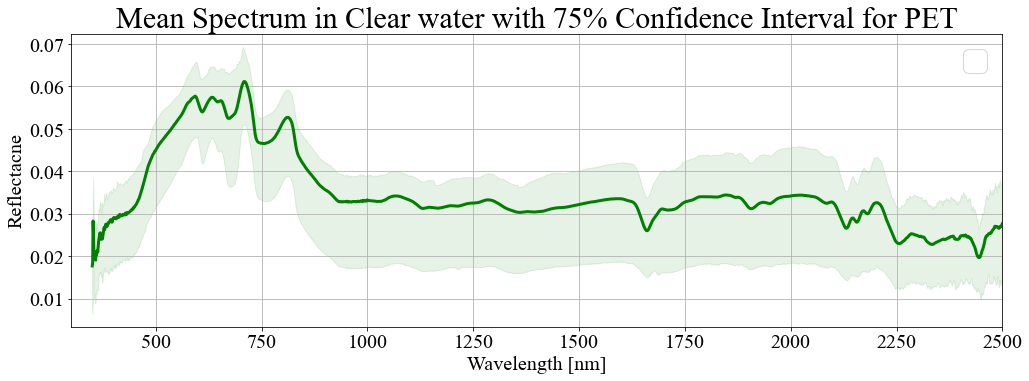

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


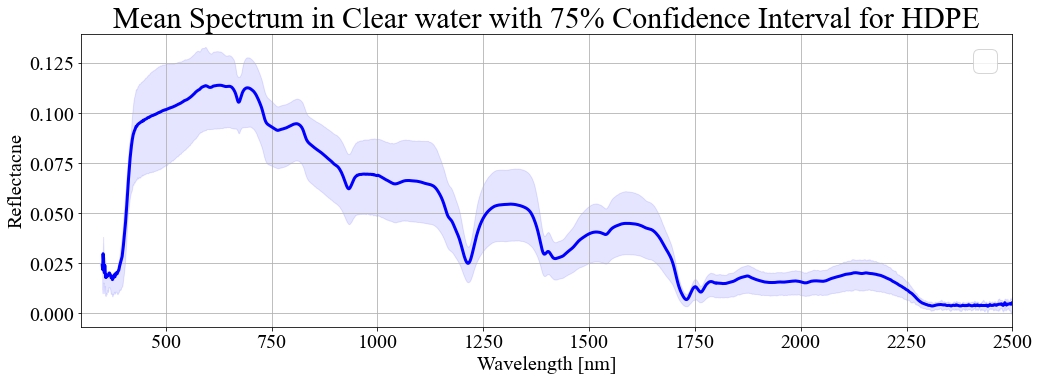

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


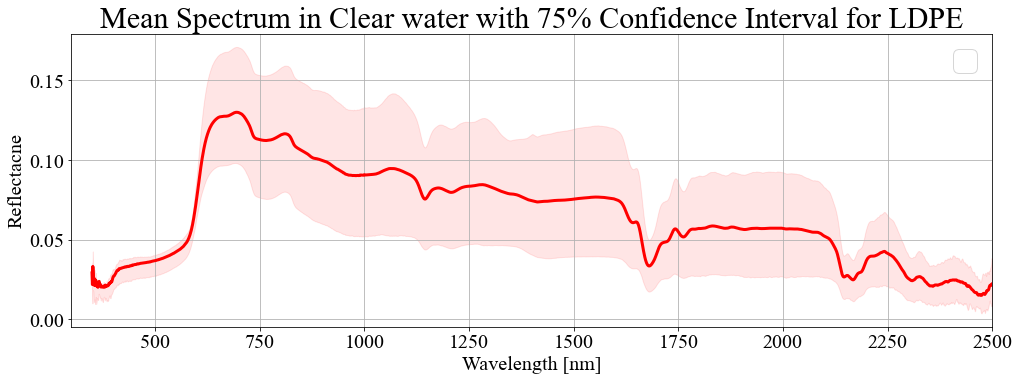

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


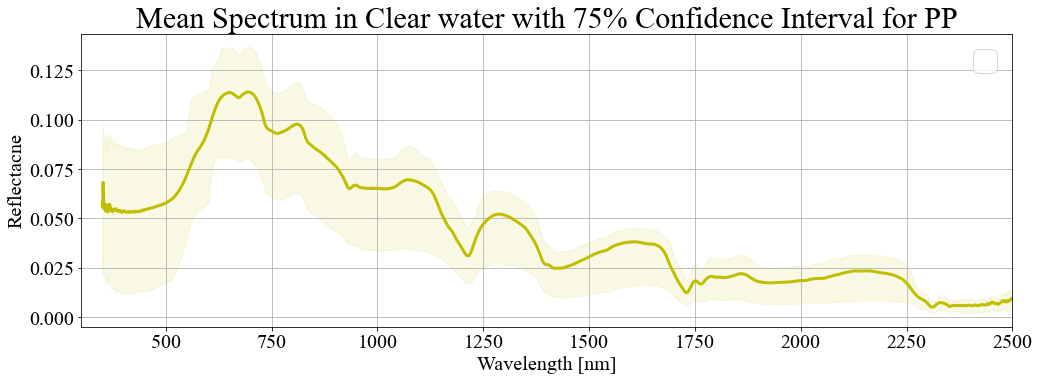

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


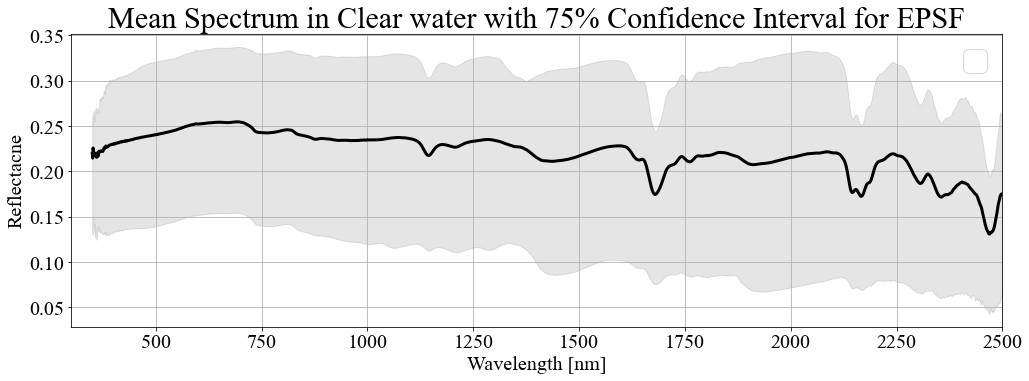

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


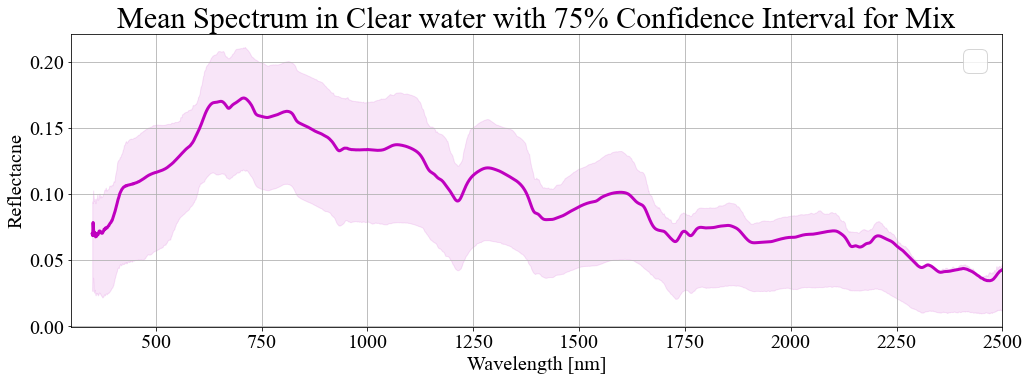

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


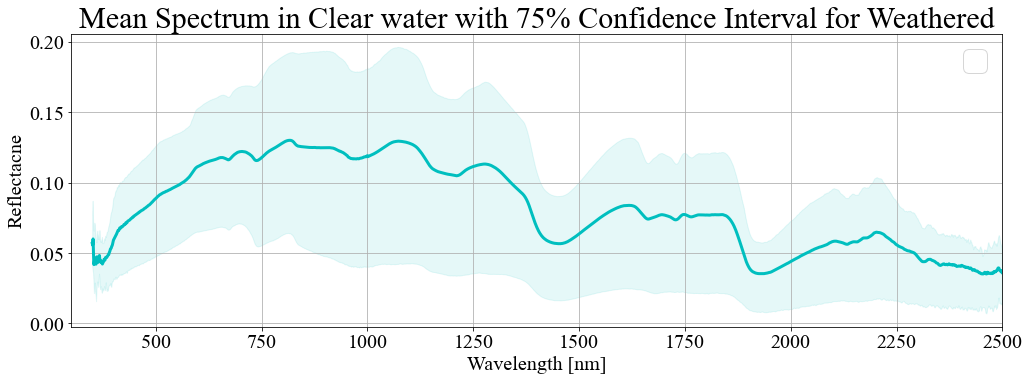

In [12]:
#Spectrum of debris in clear water with different materials
wavelengths = np.linspace(350, 2500, 2151)
confidence_level = 75 #in percentage
colors=['g','b','r','y','k','m','c'] #colors for displaying
for material, color in zip(Material_names.values(), colors):
    material_data = df[(df['Material'] == material) & (df['Background'] == 'Clear')]
    mean_spectrum = np.mean(material_data, axis=0)
    lower_bound = np.percentile(material_data.select_dtypes(include=['number']), 100-confidence_level, axis=0)
    upper_bound = np.percentile(material_data.select_dtypes(include=['number']), confidence_level, axis=0)
    plt.figure(figsize=(15, 6))
    plt.plot(wavelengths, mean_spectrum[1:], color=color, linewidth=3)
    plt.fill_between(wavelengths, lower_bound[1:], upper_bound[1:], color=color, alpha=0.1)
    plt.title(f"Mean Spectrum in Clear water with {confidence_level}% Confidence Interval for {material}", fontsize=30)
    plt.xlabel('Wavelength [nm]', fontsize=20)
    plt.xlim([300, 2500])
    plt.ylabel('Reflectacne', fontsize=20)
    plt.tick_params(axis='both', which='both', labelsize=20)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


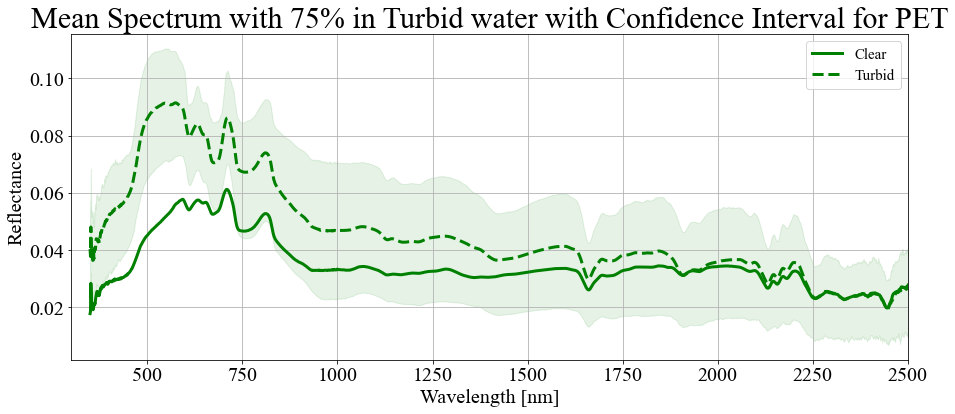

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


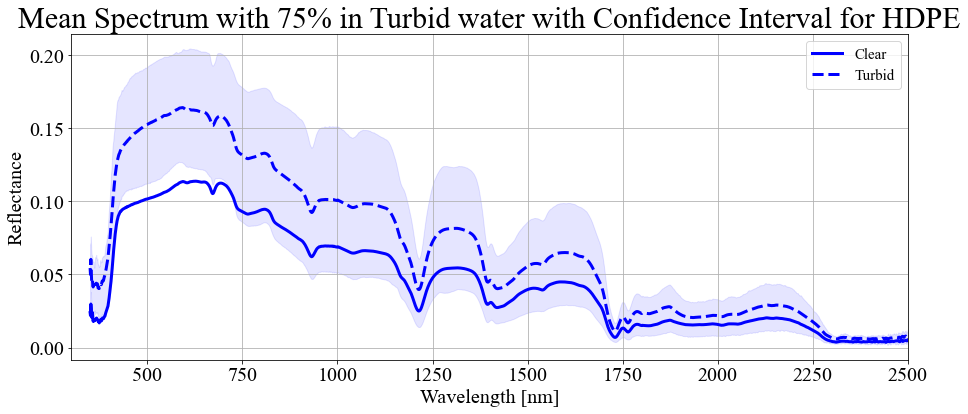

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


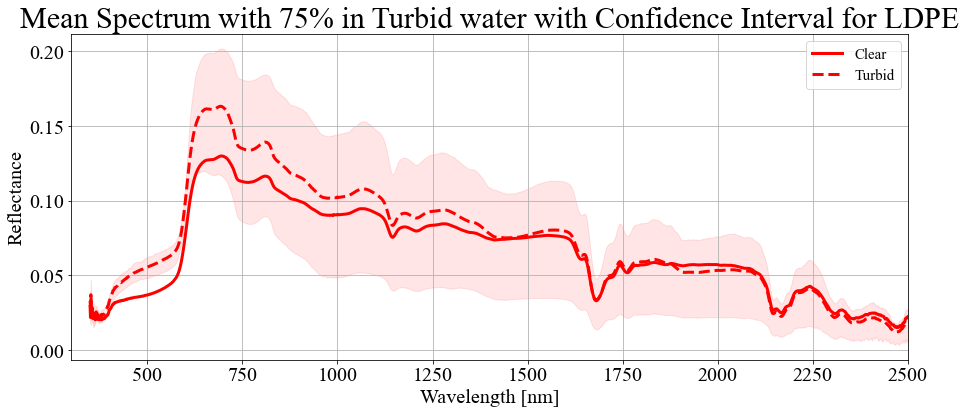

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


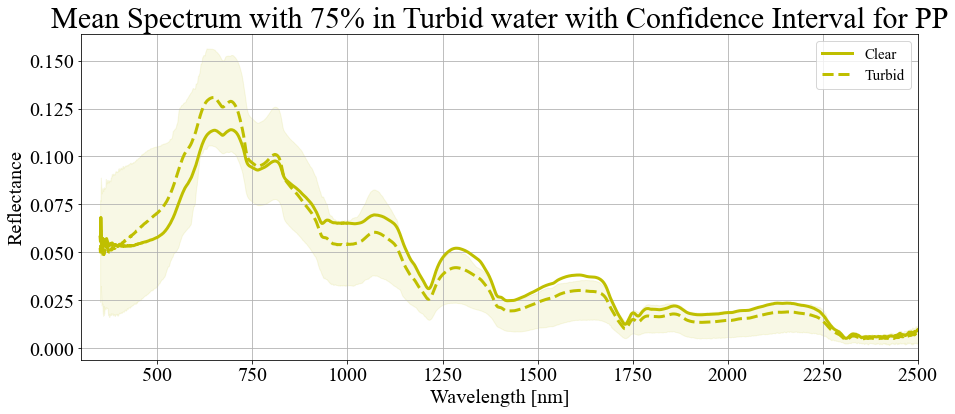

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


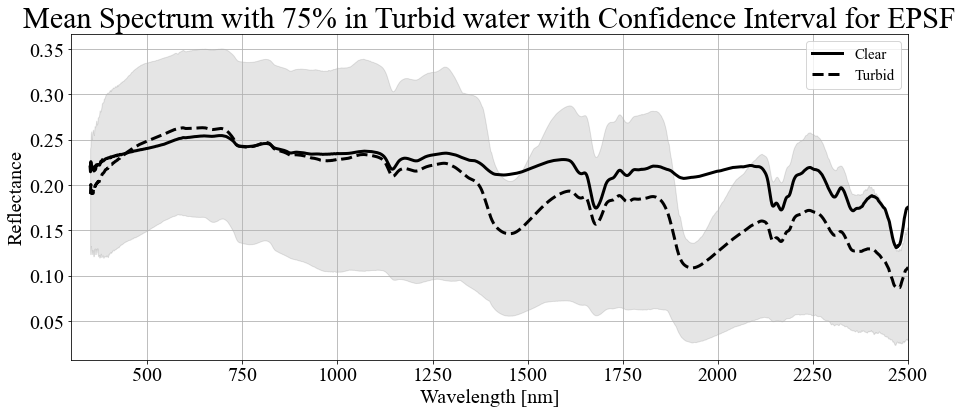

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


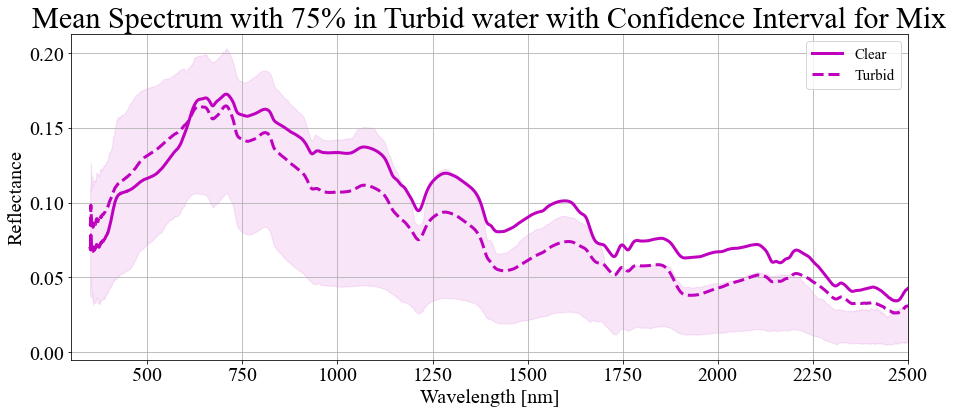

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


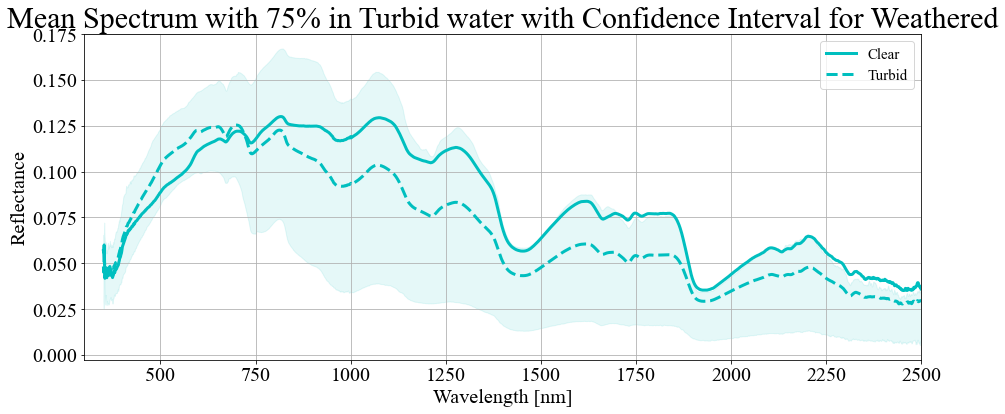

In [13]:
#Spectrum of debris in turbid Water with different materials
wavelengths = np.linspace(350, 2500, 2151)
confidence_level = 75 #in percentage
colors=['g','b','r','y','k','m','c']
legend_labels = ['Clear','Turbid']

for material, color in zip(Material_names.values(), colors):
    material_data = df[(df['Material'] == material) & (df['Background'] == 'Clear')]
    mean_spectrum = np.mean(material_data, axis=0)
    lower_bound = np.percentile(material_data.select_dtypes(include=['number']), 100-confidence_level, axis=0)
    upper_bound = np.percentile(material_data.select_dtypes(include=['number']), confidence_level, axis=0)  
    
    material_data2 = df[(df['Material'] == material) & (df['Background'] == 'Turbid')]
    mean_spectrum2 = np.mean(material_data2, axis=0)
    lower_bound2 = np.percentile(material_data2.select_dtypes(include=['number']), 100-confidence_level, axis=0)
    upper_bound2 = np.percentile(material_data2.select_dtypes(include=['number']), confidence_level, axis=0)
    
    plt.figure(figsize=(15, 6))
    plt.plot(wavelengths, mean_spectrum[1:], color=color, linewidth=3)
    plt.plot(wavelengths, mean_spectrum2[1:], linestyle='--', color=color, linewidth=3)
    plt.fill_between(wavelengths, lower_bound2[1:], upper_bound2[1:], color=color, alpha=0.1)
    plt.title(f"Mean Spectrum with {confidence_level}% in Turbid water with Confidence Interval for {material}", fontsize=30)
    plt.xlabel('Wavelength [nm]', fontsize=20)
    plt.xlim([300, 2500])
    plt.ylabel('Reflectance', fontsize=20)
    plt.tick_params(axis='both', which='both', labelsize=20)
    plt.grid(True)
    plt.legend(legend_labels, fontsize="15")
    plt.show()

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


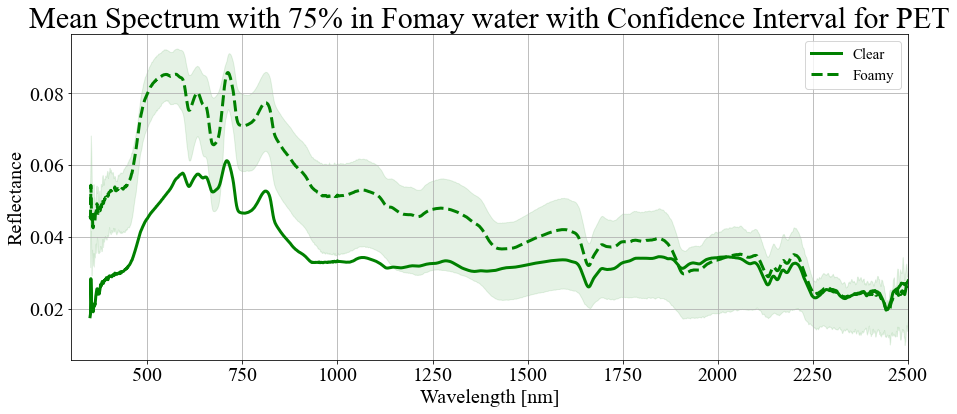

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


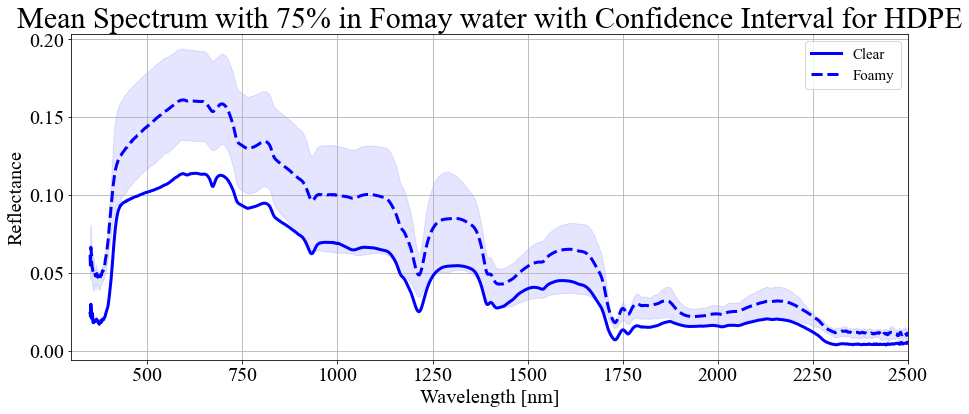

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


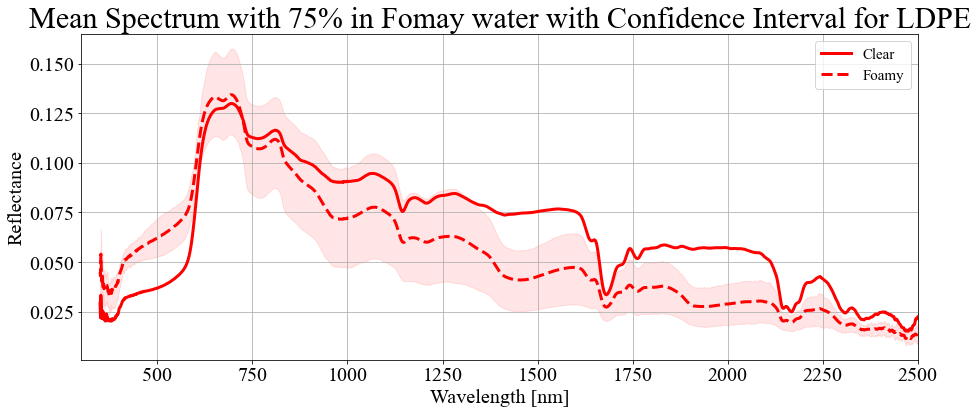

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


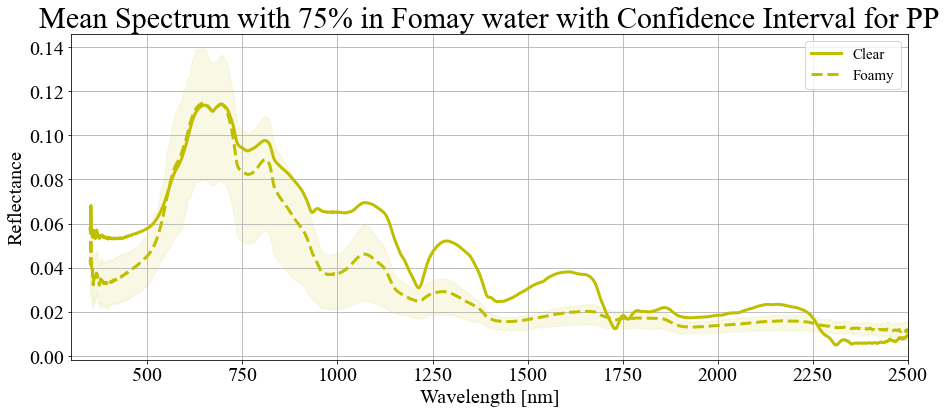

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


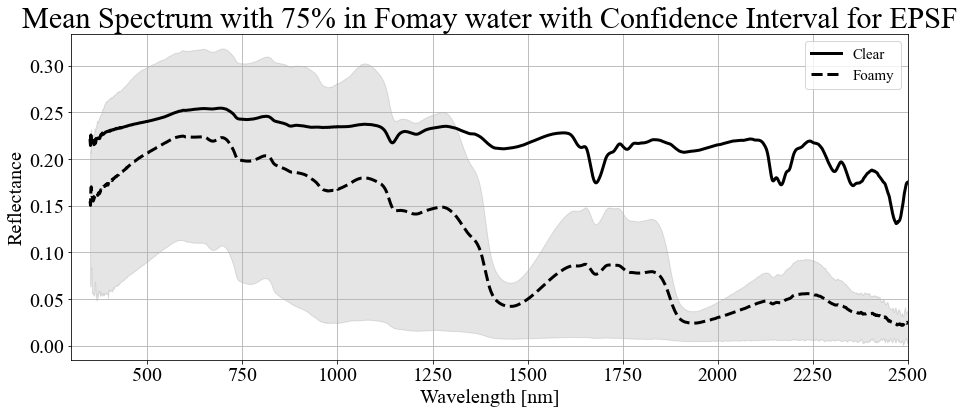

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


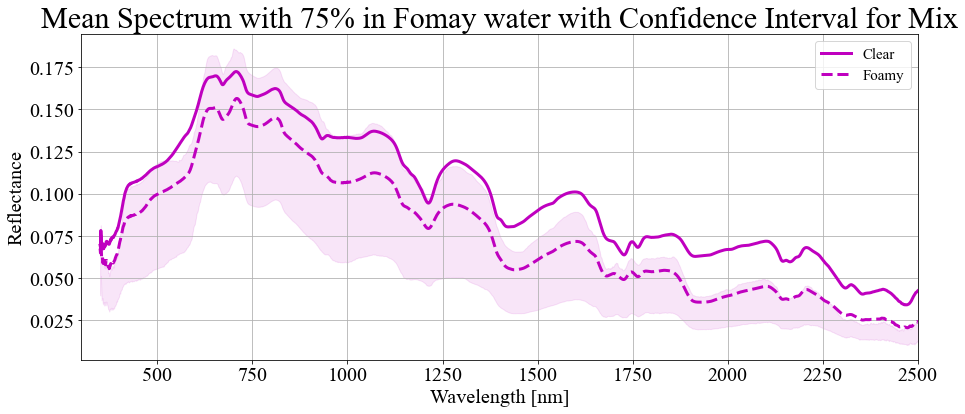

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


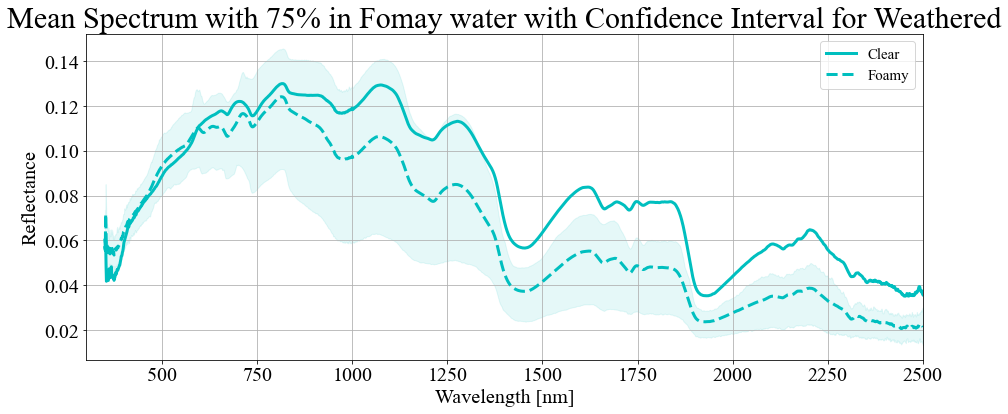

In [14]:
##Spectrum of debris in foamy Water with different materials
wavelengths = np.linspace(350, 2500, 2151)
confidence_level = 75 #in percentage
colors=['g','b','r','y','k','m','c']
legend_labels = ['Clear','Foamy']

for material, color in zip(Material_names.values(), colors):
    material_data = df[(df['Material'] == material) & (df['Background'] == 'Clear')]
    mean_spectrum = np.mean(material_data, axis=0)
    lower_bound = np.percentile(material_data.select_dtypes(include=['number']), 100-confidence_level, axis=0)
    upper_bound = np.percentile(material_data.select_dtypes(include=['number']), confidence_level, axis=0)  
    
    material_data3 = df[(df['Material'] == material) & (df['Background'] == 'Foamy')]
    mean_spectrum3 = np.mean(material_data3, axis=0)
    lower_bound3 = np.percentile(material_data3.select_dtypes(include=['number']), 100-confidence_level, axis=0)
    upper_bound3 = np.percentile(material_data3.select_dtypes(include=['number']), confidence_level, axis=0)

    plt.figure(figsize=(15, 6))
    plt.plot(wavelengths, mean_spectrum[1:], color=color, linewidth=3)
    plt.plot(wavelengths, mean_spectrum3[1:], linestyle='--', color=color, linewidth=3)
    plt.fill_between(wavelengths, lower_bound3[1:], upper_bound3[1:], color=color, alpha=0.1)
    plt.title(f"Mean Spectrum with {confidence_level}% in Fomay water with Confidence Interval for {material}", fontsize=30)
    plt.xlabel('Wavelength [nm]', fontsize=20)
    plt.xlim([300, 2500])
    plt.ylabel('Reflectance', fontsize=20)
    # Increase font size of numbers on both x and y-axis
    plt.tick_params(axis='both', which='both', labelsize=20)
    plt.grid(True)
    plt.legend(legend_labels,fontsize="15")
    plt.show()

c:\Users\olyae001\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\olyae001\AppData\Local\Temp\ipykernel_3360\1318833346.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


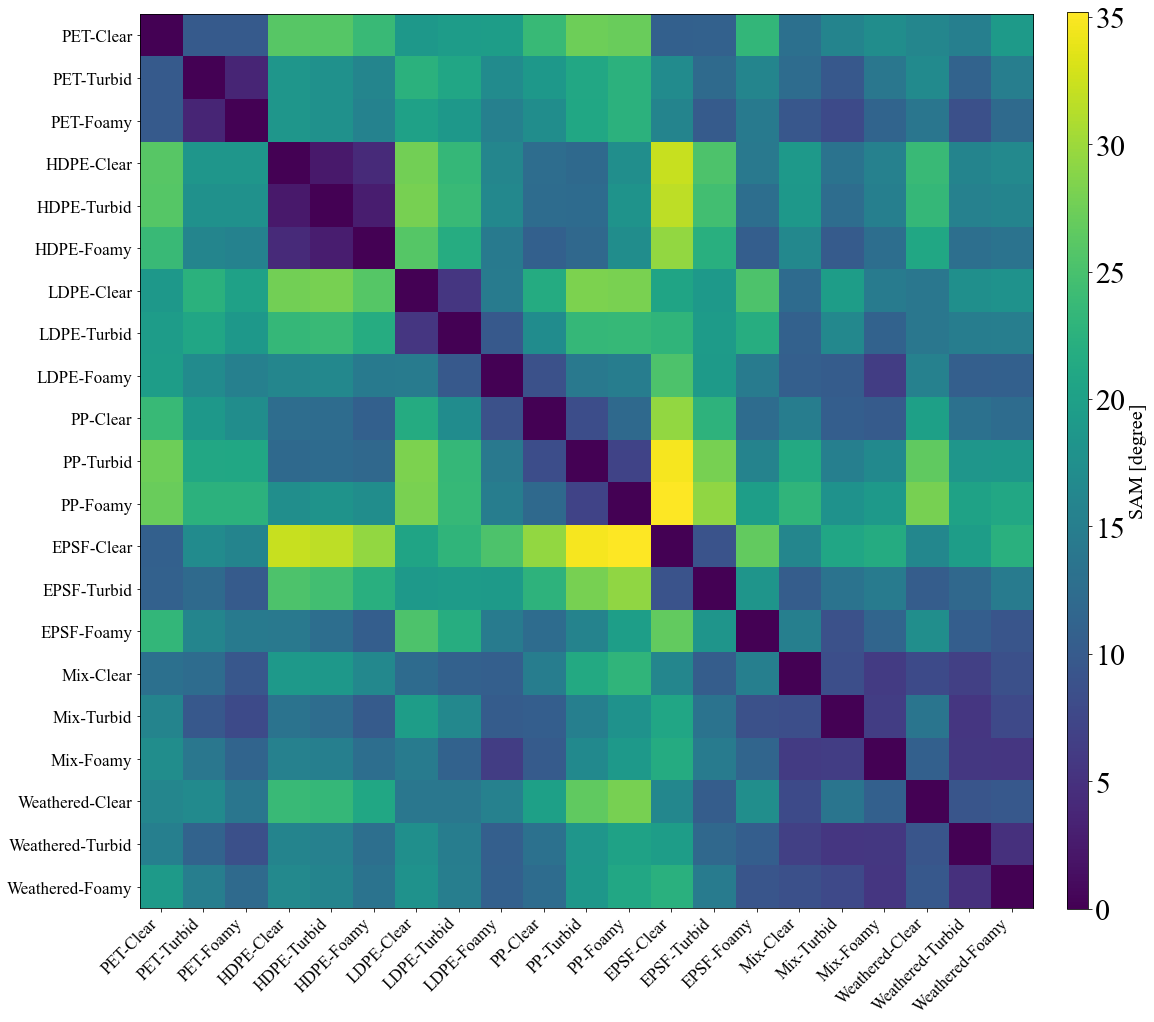

In [15]:
#Heatmap of spectral angle mapper (SAM) between the mean spectrum in each combo states (21 SAM in total)
def SAM(spectrum1, spectrum2):
    spectrum1_normalized = spectrum1/LA.norm(spectrum1)
    spectrum2_normalized = spectrum2/LA.norm(spectrum2)
    if (spectrum1_normalized==spectrum2_normalized).all(): #same spectrum
        return(0)
    else:
        return(math.acos(np.dot(spectrum1_normalized,spectrum2_normalized))*180/math.pi) #inverse cosine
def calculate_sam_partial(spectra, index): #index is a tuple with two components showing the number of spectrum
    return SAM(spectra[index[0]], spectra[index[1]])   

#Building the spectra based on the mean spectrum of all combo states (21 spectrum in total)
spectra=[]
for i in sorted(df['code'].unique().tolist()):
    mean_spectrum = np.mean(df[df['code']==i], axis=0)
    spectra.append(mean_spectrum[1:])

indices = [(i, j) for i in range(len(spectra)) for j in range(len(spectra))]
#partial function is used for fixing the spectra arguments of a calculate_sam_partial function 
partial_sam=partial(calculate_sam_partial,spectra)
SAM_matrix=list(map(partial_sam,indices))
SAM_matrix_final=np.array(SAM_matrix).reshape((21,21))

# Create a heatmap
fig, ax = plt.subplots(figsize=(15, 15))
# Plot the data
plot1 = ax.imshow(SAM_matrix_final, cmap='viridis', interpolation='nearest')
# Manually set x and y labels
x_labels = [Material_names[x//10]+'-'+Background_names[x%10] for x in sorted(df['code'].unique().tolist())]  
y_labels = x_labels
plt.xticks(np.arange(21), x_labels, fontsize=17, rotation=45, ha='right')
plt.yticks(np.arange(21), y_labels, fontsize=17)
#color bar
cbar_ax = fig.add_axes([1.001, 0.135, 0.02, 0.83])
cbar = fig.colorbar(plot1, cax=cbar_ax, orientation="vertical")
cbar.set_label('SAM [degree]', fontsize=20)
plt.tight_layout()
plt.show()

In [16]:
#Apply XGboost classifier 
target={'PET','HDPE','LDPE','PP','EPSF'} #Five classes based on the single polymers i.e. (PET,HDPE,LDPE,PP,EPSF)
Query=df[df['Material'].isin(target)]  #Query the dataset based on the dataset
X=Query.select_dtypes(include=['number']).iloc[:,1:] #Selecting reflectacne wavelength 350-2500 nm hyperspectral reflectacne
y=[(i//10)-1 for i in Query['code']]
print(f'The size of X and y are {X.shape} and {len(y)}, respectively')

The size of X and y are (815, 2151) and 815, respectively


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Check the sizes of the resulting arrays
print(f'Training set size for X_train: {X_train.shape}, y_train: {len(y_train)}')
print(f'Test set size for X_test: {X_test.shape}, y_test: {len(y_test)}')

Training set size for X_train: (570, 2151), y_train: 570
Test set size for X_test: (245, 2151), y_test: 245


In [18]:
#Load the pre-trained model (Run the next cell for training the model from the scratch)
model_xgb_virgin = xgb.XGBClassifier()
model_xgb_virgin.load_model('model_xgb_virgin.json')

#Accuracy score of train data
print(f'Accuracy score of the model for the training data is {model_xgb_virgin.score(X_train,y_train)*100}')

Accuracy score of the model for the training data is 100.0


In [ ]:
# Fit model to the training data (skip if the previous cell was run)
model_xgb_virgin = XGBClassifier(max_depth = 13, eta = 0.05, n_estimators = 200)
model_xgb_virgin.fit(X_train, y_train)

In [19]:
#Apply to the test data
y_pred=model_xgb_virgin.predict(X_test)

#Accuracy score 
print(f'Accuracy score of the model for the test data is {accuracy_score(y_test,y_pred)*100}')

#Classification report
print(f'Classification report: \n {classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4], target_names = ["PET", "HDPE", "LDEP", "PP", "EPSF"])}')

Accuracy score of the model for the test data is 94.28571428571428
Classification report: 
               precision    recall  f1-score   support

         PET       0.93      0.98      0.96        56
        HDPE       1.00      0.93      0.96        43
        LDEP       0.96      0.92      0.94        51
          PP       0.90      0.94      0.92        70
        EPSF       0.96      0.92      0.94        25

    accuracy                           0.94       245
   macro avg       0.95      0.94      0.94       245
weighted avg       0.94      0.94      0.94       245



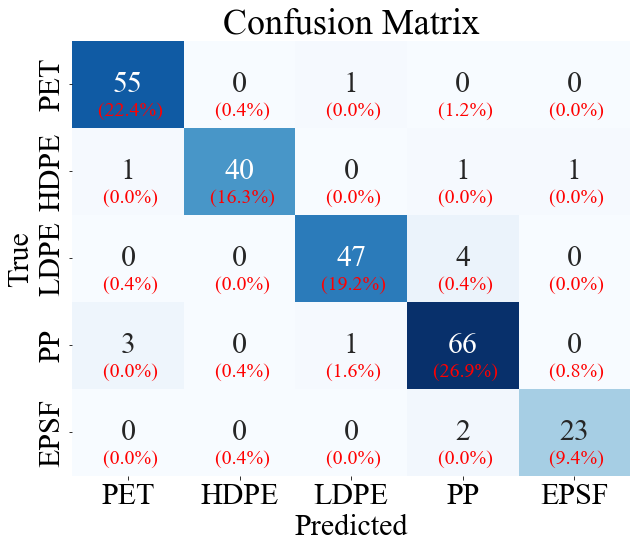

In [21]:
# Assuming you already have y_test and y_pred
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum() * 100

# Plotting the heatmap with counts and percentages
plt.figure(figsize=(10, 8))

# Display counts in each cell
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['PET','HDPE','LDPE','PP','EPSF'], yticklabels=['PET','HDPE','LDPE','PP','EPSF'])

# Display percentages beneath the counts
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(i + 0.5, j+0.8 , f" ({conf_matrix_percent[i, j]:.1f}%)",
                 ha='center', va='center', color='red', fontsize=20)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Get feature importance scores based on XGboost model
feature_importance = model_xgb_virgin.feature_importances_

2151

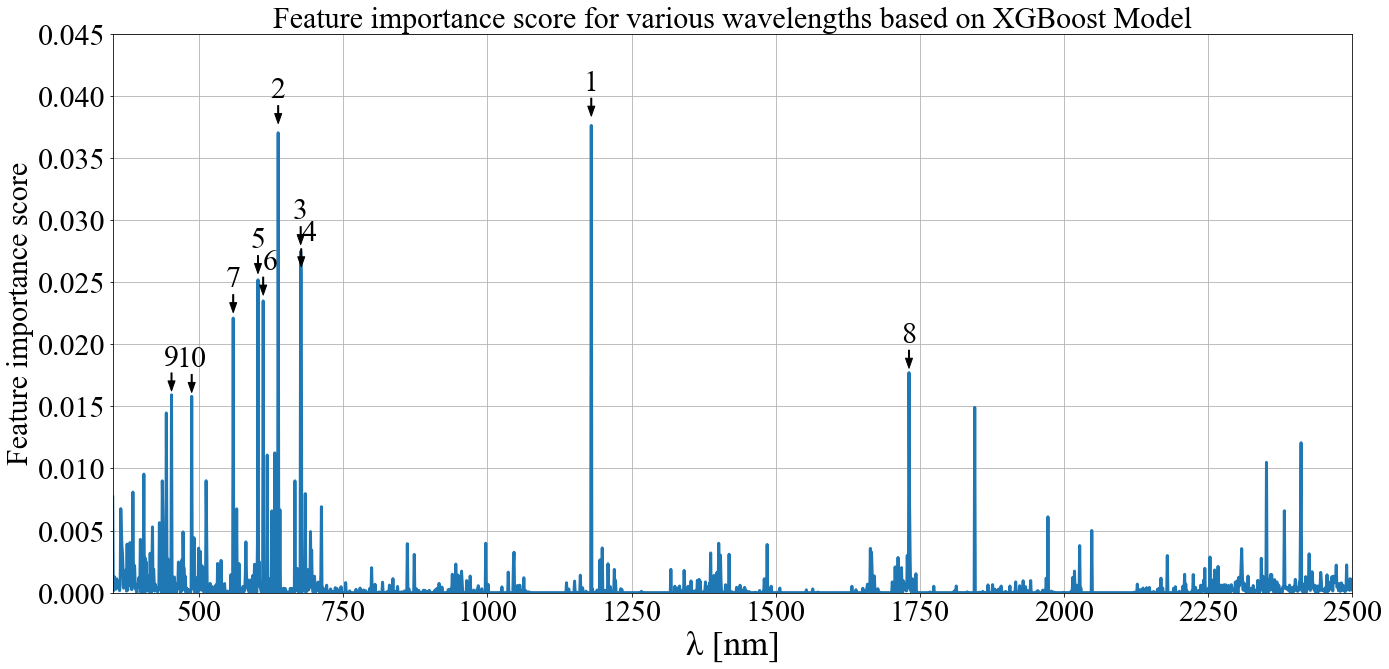

In [256]:
data = np.column_stack((wavelengths, feature_importance))
k=10 #Number of top wavelengths displayed
sort_indices=data[:,1].argsort()[::-1] #Sorting the indices in descending order
sorted_data=data[sort_indices[:k],:]

plt.figure(figsize=(20, 10))
plt.plot(wavelengths, feature_importance, linewidth=3)
plt.title('Feature importance score for various wavelengths based on XGBoost Model', fontsize=30)
plt.xlabel(f'{chr(955)} [nm]', fontsize=35)
ha=['left' if i in [3,5] else 'center' for i in range(k)] #adjust the horizontal alignment for index=[3,5] to avoid overlapping in the visualization 
for i in range(sorted_data.shape[0]):
    plt.annotate(f"{i+1}",(sorted_data[i, 0], 1.02 * sorted_data[i, 1]),
                 textcoords="offset points",
                 xytext=(0, 20), ha=ha[i], va='bottom',
                 arrowprops = dict(facecolor ='black',width=1, headwidth=7, headlength=10),
                 color='black', fontsize=30)
plt.xlim([350, 2500])
plt.ylim([0,0.045])
plt.ylabel('Feature importance score', fontsize=30)
plt.tick_params(axis='both', which='both', labelsize=30)
plt.grid(True)
plt.tight_layout()
plt.show()